In [1]:
#Imported Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.svm import OneClassSVM

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Loaded NSL-KDD Dataset
columns = [
    'duration','protocol_type','service','flag','src_bytes','dst_bytes',
    'land','wrong_fragment','urgent','hot','num_failed_logins','logged_in',
    'num_compromised','root_shell','su_attempted','num_root',
    'num_file_creations','num_shells','num_access_files','num_outbound_cmds',
    'is_host_login','is_guest_login','count','srv_count','serror_rate',
    'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate',
    'diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count',
    'dst_host_same_srv_rate','dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate','dst_host_srv_diff_host_rate',
    'dst_host_serror_rate','dst_host_srv_serror_rate',
    'dst_host_rerror_rate','dst_host_srv_rerror_rate','label'
]

df = pd.read_csv("KDDTrain+.txt", names=columns)
print(df.head())

  duration protocol_type service  flag  src_bytes  dst_bytes  land  \
0      tcp      ftp_data      SF   491          0          0     0   
0      udp         other      SF   146          0          0     0   
0      tcp       private      S0     0          0          0     0   
0      tcp          http      SF   232       8153          0     0   
0      tcp          http      SF   199        420          0     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                0.17   
0               0       0    0  ...                0.00   
0               0       0    0  ...                0.10   
0               0       0    0  ...                1.00   
0               0       0    0  ...                1.00   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.03                    0.17   
0                    0.60                    0.88   
0                    0.05                    0.00   
0           

In [3]:
#Dataset Exploration
df['label'].value_counts().head(10)
df.info
df.shape


label
21    62557
18    20667
20    19339
19    10284
15     3990
17     3074
16     2393
12      729
14      674
11      641
Name: count, dtype: int64

In [ ]:
#Feature Categorization
#Basic -> duration, protocol_type, service
#Content-Based -> hot, num_failed_logins
#Time-Based -> count,srv_count
#Host-Based -> dst_host_count, dst_host_srv_count

In [4]:
#Data Preprocessing
#1.Encode Categorial Features
categorical_cols = ['protocol_type', 'service', 'flag']

existing_cols = [col for col in categorical_cols if col in df.columns]

if existing_cols:
    df = pd.get_dummies(df, columns=existing_cols)


In [5]:
for col in df.select_dtypes(include='object').columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [6]:
df.select_dtypes(include='object').columns


Index([], dtype='object')

In [7]:
df = df.copy()


In [8]:
#2.Binary Label Creation
df['binary_label'] = (df['label'] != 0).astype(int)


In [9]:
df['binary_label'].value_counts()


binary_label
1    125907
0        66
Name: count, dtype: int64

In [10]:
X = df.drop(columns=['label', 'binary_label'])
y = df['binary_label']


In [11]:
X.select_dtypes(include='object').columns


Index([], dtype='object')

In [12]:
#3.Train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [13]:
y_train.value_counts()
y_train.nunique()


2

In [14]:
X_train = pd.DataFrame(X_train, columns=X.columns)


In [17]:
#4.Feature Scaling
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

# Remove zero-variance features
vt = VarianceThreshold(threshold=0.0)
X_train = vt.fit_transform(X_train)
X_test = vt.transform(X_test)

# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [19]:
#Task A - Binary Classification
#Logistic Regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = lr.predict(X_test)

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1-score :", f1_score(y_test, y_pred))


Accuracy : 0.9996824766818814
Precision: 0.9997617724132455
Recall   : 0.9999205781907712
F1-score : 0.999841168996188


In [21]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier, IsolationForest

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1:", f1_score(y_test, y_pred_rf))


Accuracy: 0.9996427862671164
Precision: 0.9996427295462665
Recall: 1.0
F1: 0.9998213328568876


In [22]:
#Task B - Multi-Class Classification
#Attack Type Mapping

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

# 1. Map numeric labels to attack classes
# Assumption: label 0 = Normal, others = attacks (NSL-KDD standard)
def map_attack_class(label):
    if label == 0:
        return 'Normal'
    elif label in [1, 2, 3, 4]:
        return 'DoS'
    elif label in [5, 6, 7]:
        return 'Probe'
    elif label in [8, 9, 10]:
        return 'R2L'
    elif label in [11, 12]:
        return 'U2R'
    else:
        return 'Other'

df = df.copy()  # prevent fragmentation warnings
df['attack_class'] = df['label'].apply(map_attack_class)

# 2. Prepare features and target
X_multi = df.drop(columns=['label', 'binary_label', 'attack_class'])
y_multi = df['attack_class']

#3. Train-test split (STRATIFIED)
X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_multi,
    y_multi,
    test_size=0.2,
    random_state=42,
    stratify=y_multi
)

# 4. Handle NaN values
X_train_m = X_train_m.fillna(0)
X_test_m = X_test_m.fillna(0)

# 5. Remove zero-variance features
vt = VarianceThreshold(threshold=0.0)
X_train_m = vt.fit_transform(X_train_m)
X_test_m = vt.transform(X_test_m)

# 6. Feature Scaling
scaler = StandardScaler()
X_train_m = scaler.fit_transform(X_train_m)
X_test_m = scaler.transform(X_test_m)

print("Train shape:", X_train_m.shape)
print("Test shape :", X_test_m.shape)
print("Classes    :", y_multi.unique())

Train shape: (100778, 3174)
Test shape : (25195, 3174)
Classes    : ['Other' 'U2R' 'DoS' 'R2L' 'Probe' 'Normal']


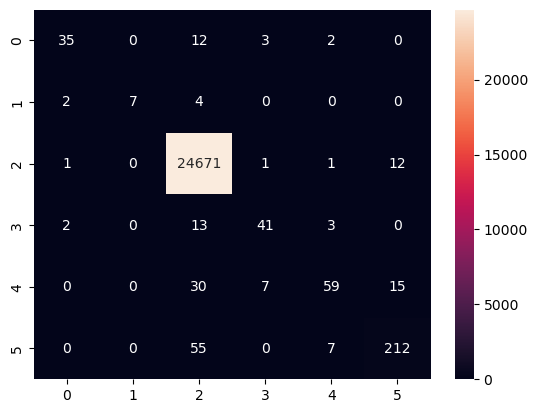

Macro F1: 0.7780533633481745


In [23]:
#Random Forest(Multi-class)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score
rf_multi = RandomForestClassifier(n_estimators=100, random_state=42)
rf_multi.fit(X_train_m, y_train_m)

y_pred_multi = rf_multi.predict(X_test_m)

cm = confusion_matrix(y_test_m, y_pred_multi)
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

print("Macro F1:", f1_score(y_test_m, y_pred_multi, average='macro'))


In [24]:
#Task C: Anomaly Detection
#Isolation Forest
normal_data = X_train[y_train == 0]

iso = IsolationForest(contamination=0.1, random_state=42)
iso.fit(normal_data)

y_pred_anomaly = iso.predict(X_test)
y_pred_anomaly = np.where(y_pred_anomaly == -1, 1, 0)

print("Detection Rate:", recall_score(y_test, y_pred_anomaly))
print("False Positive Rate:", 1 - precision_score(y_test, y_pred_anomaly))



Detection Rate: 0.0574616789770471
False Positive Rate: 0.0013802622498274575


In [40]:
#Feature importance

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# 1. Prepared full feature set 
X_full = df.drop(columns=['label', 'binary_label', 'attack_class'], errors='ignore')
y = df['binary_label']

# 2. Trained Random Forest on Raw dataframe 
rf = RandomForestClassifier(
    n_estimators=50,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_full, y)

# 3.Feature Importance 
feat_imp = pd.DataFrame({
    'Feature': X_full.columns,
    'Importance': rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Top 15 Important Features:")
display(feat_imp.head(15))

# 4.Top 15 Features
top_features = feat_imp['Feature'].head(15).tolist()
X_reduced = X_full[top_features]

# 5. Train-test split
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_reduced,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 6. Scaling 
scaler = StandardScaler()
X_train_r = scaler.fit_transform(X_train_r)
X_test_r = scaler.transform(X_test_r)

# 7. Train Logistic Regression
lr_reduced = LogisticRegression(max_iter=1000)
lr_reduced.fit(X_train_r, y_train_r)

# 8. Evaluation
y_pred_r = lr_reduced.predict(X_test_r)
print("Reduced Feature F1 Score:", f1_score(y_test_r, y_pred_r))


Top 15 Important Features:


,Feature,Importance
450,flag_334,0.159281
29,dst_host_srv_count,0.086883
28,dst_host_count,0.076957
27,srv_diff_host_rate,0.067869
30,dst_host_same_srv_rate,0.067534
31,dst_host_diff_srv_rate,0.063070
1,src_bytes,0.039566
32,dst_host_same_src_port_rate,0.038699
1791,flag_1710,0.037244
18,is_guest_login,0.035721


Reduced Feature F1 Score: 0.9997816203768041
